# Library

In [ ]:
!pip install langchain_community
!pip install replicate
!pip install pandas
!pip install matplotlib
!pip install wordcloud
!pip install seaborn

In [4]:
# Import semua pustaka yang akan digunakan
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import os
from google.colab import userdata  # Mengambil API token yang disimpan di Colab
from langchain_community.llms import Replicate  # Library untuk integrasi LLM via Replicate
import random

# Load Dataset

In [5]:
# Membaca file CSV dengan hanya mengambil kolom Text dan Summary
df = pd.read_csv("bbc_news_data.csv", usecols=['Text', 'Summary'])

In [9]:
# Menampilkan kolumn data text dan summary
df

,Text,Summary
0,US consumer confidence up\n\nConsumers' confid...,"Wal-Mart, the largest US retailer, has said it..."
1,The 'ticking budget' facing the US\n\nThe budg...,Brute force budget cuts or spending caps would...
2,Mitsubishi in Peugeot link talks\n\nTrouble-hi...,Trouble-hit Mitsubishi Motors is in talks with...
3,BMW reveals new models pipeline\n\nBMW is prep...,Typically it takes about three years from when...
4,World leaders gather to face uncertainty\n\nMo...,"More than 2,000 business and political leaders..."
...,...,...
2220,Sun offers processing by the hour\n\nSun Micro...,Sun likened grid computing to the development ...
2221,Mobile gaming takes off in India\n\nGaming on ...,India's mobile gaming market will bring in abo...
2222,Apple sues to stop product leaks\n\nComputer f...,"In a statement, Apple said of the current laws..."
2223,Digital guru floats sub-$100 PC\n\nNicholas Ne...,"He said one laptop per child could be "" very i..."


In [10]:
# Menghapus baris yang memiliki nilai kosong (null) di salah satu kolom
df.dropna(inplace=True)

In [11]:
# Mereset index dataframe setelah pembersihan
df.reset_index(drop=True, inplace=True)

In [12]:
# Menampilkan 5 data pertama sebagai preview
df.head()

,Text,Summary
0,US consumer confidence up\n\nConsumers' confid...,"Wal-Mart, the largest US retailer, has said it..."
1,The 'ticking budget' facing the US\n\nThe budg...,Brute force budget cuts or spending caps would...
2,Mitsubishi in Peugeot link talks\n\nTrouble-hi...,Trouble-hit Mitsubishi Motors is in talks with...
3,BMW reveals new models pipeline\n\nBMW is prep...,Typically it takes about three years from when...
4,World leaders gather to face uncertainty\n\nMo...,"More than 2,000 business and political leaders..."


#  Preprocessing

In [13]:
# Membuat kolom baru: panjang teks artikel berdasarkan jumlah kata
df['text_len'] = df['Text'].apply(lambda x: len(x.split()))

In [14]:
# Membuat kolom baru: panjang ringkasan berdasarkan jumlah kata
df['summary_len'] = df['Summary'].apply(lambda x: len(x.split()))

# EDA & Visualisasi

Distribusi Panjang Artikel

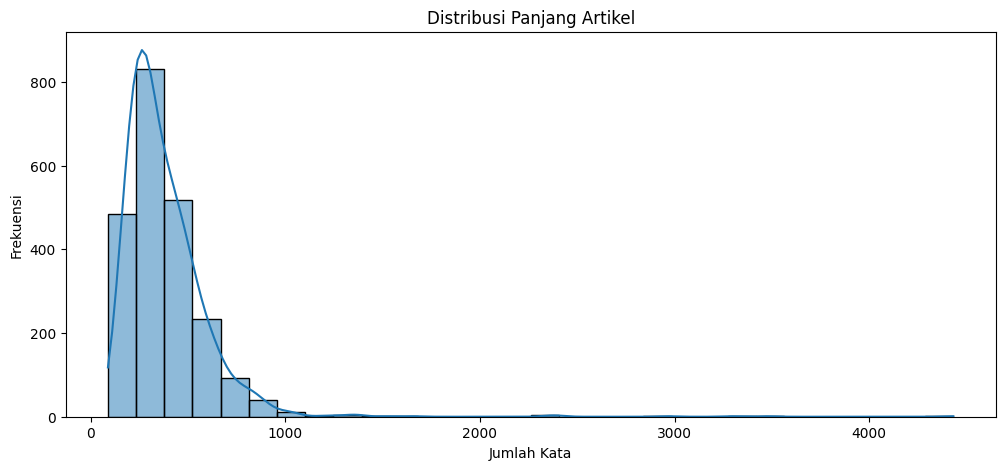

In [15]:
# Visualisasi distribusi panjang artikel dalam jumlah kata
plt.figure(figsize=(12, 5))
sns.histplot(df['text_len'], bins=30, kde=True)
plt.title('Distribusi Panjang Artikel')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()

WordCloud dari Artikel

In [16]:
# Membuat WordCloud dari gabungan 300 artikel acak
text_cloud = ' '.join(df['Text'].sample(300))

In [17]:
# Membuat wordcloud dari kumpulan kata tersebut
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_cloud)

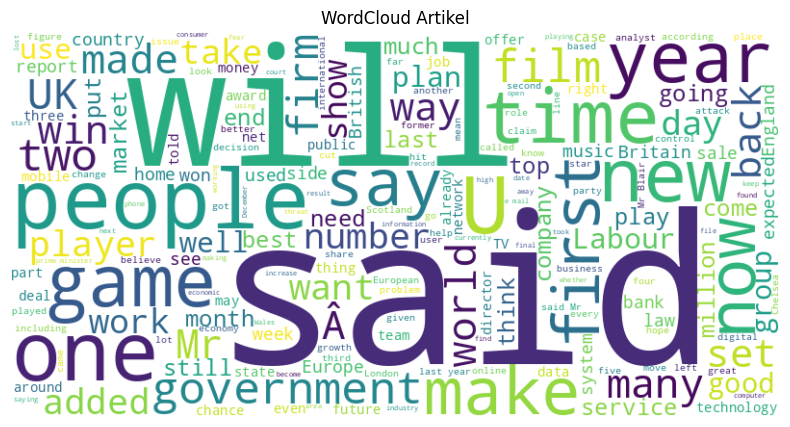

In [18]:
# Menampilkan wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Artikel')
plt.show()

# Setup IBM Granite (via Replicate API)

In [19]:
# Mengambil API token dari Google Colab Secret
api_token = userdata.get('api_token')

# Set environment agar token dikenali oleh library Replicate
os.environ["REPLICATE_API_TOKEN"] = api_token

# Menentukan model IBM Granite yang akan digunakan
model = "ibm-granite/granite-3.3-8b-instruct"

# Membuat objek output untuk menjalankan prompt terhadap model
output = Replicate(
    model=model,
    replicate_api_token=api_token,
)


# Summarization dengan Prompt Bahasa Indonesia

In [21]:
# Ambil 5 artikel acak dari DataFrame utama
samples = df.sample(5, random_state=42).copy()

In [22]:
# Menambahkan kolom kosong untuk hasil ringkasan dari model Granite
samples['Granite_Summary'] = ''

In [23]:
# Melakukan proses summarization per artikel
for idx, row in samples.iterrows():
    article = row['Text'][:1500]  # Potong artikel jika terlalu panjang (batas token)

    # Prompt untuk merangkum artikel
    prompt = f"""
Ringkas artikel berita berikut menjadi satu paragraf yang menyampaikan intisarinya:

{article}
"""

In [25]:
# Parameter pemanggilan model
parameters = {
    "top_k": 0,
    "top_p": 1.0,
    "max_tokens": 256,
    "min_tokens": 0,
    "random_seed": None,
    "repetition_penalty": 1.0,
    "stopping_criteria": "length (256 tokens)",
    "stopping_sequence": None
}

In [28]:
# Memanggil model dan menyimpan hasil ke kolom baru
response = output.invoke(prompt, parameters=parameters)
samples.at[idx, 'Granite_Summary'] = response

In [29]:
# Tampilkan hasil summarization Granite vs Summary asli
samples[['Text', 'Summary', 'Granite_Summary']]

,Text,Summary,Granite_Summary
414,Yukos seeks court action on sale\n\nYukos will...,Yukos will return to a US court on Wednesday t...,
420,House prices show slight increase\n\nPrices of...,"House prices have risen 0.9% this year, Nation...",
1644,Greek duo cleared in doping case\n\nSprinters ...,"Kenteris's lawyer, Gregory Ioannidis, said: ""T...",
416,Euro firms miss out on optimism\n\nMore than 9...,"Possibly as a result, the worry about low-cost...",
1232,Brown ally rejects Budget spree\n\nChancellor ...,"But Mr Balls, a prospective Labour MP, said he...","Ed Balls, a close ally and former chief econom..."


In [30]:
# Tampilkan ringkasan hasil AI saja
samples[['Granite_Summary']].head()

,Granite_Summary
414,
420,
1644,
416,
1232,"Ed Balls, a close ally and former chief econom..."


In [31]:
for idx, row in samples.iterrows():
    ...
    response = output.invoke(prompt, parameters=parameters)
    samples.at[idx, 'Granite_Summary'] = response
    print(f"\n📰 Artikel {idx+1} diringkas:")
    print(response)


📰 Artikel 415 diringkas:
Ed Balls, former chief economic adviser to the Treasury and prospective Labour MP, has refuted claims of an impending Budget spending spree by Chancellor Gordon Brown ahead of the March 16 Budget announcement and the anticipated May election. Balls, who recently resigned from his Treasury position to contest the election, expressed confidence that Brown would adhere to his fiscal rules, emphasizing that the Chancellor would meet his "golden rule" with room to spare. Balls also advocated for enhancements to existing tax credit systems. Amidst growing expectations of an interest rate hike by the Bank of England due to robust economic indicators like rising house prices and increased consumer borrowing, Balls downplayed the potential impact on Labour's election prospects. He asserted that an interest rate increase, should it occur before the election due to economic strength, would not significantly affect Labour's chances, marking a shift in British political di

In [34]:
# Menyimpan hasil akhir sebagai file CSV
samples.to_csv('granite_summary_output.csv')